In [1]:
from project_lib import *
import itertools

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

In [3]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples',
                'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
                'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
                'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 100


SIGMA_WDW = 63
GAMMA = None

In [4]:
trades_list, trades_pnl = run_bt_pipeline(df,
            TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

strategy_sharpe = (trades_list['sharpe_ratio']*trades_list['weight']).sum()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:46<00:00,  2.30s/it]


In [4]:
# Grid search for strategy optimal paramenters

GS_long_pctle = [{10:0.1, 21:0.2, 63:0.3},
                 {5:0.1, 10:0.2, 15:0.3},
                 {20:0.1, 40:0.2, 70:0.3}]

GS_short_pctle = [{10:1-0.1, 21:1-0.2, 63:1-0.3},
                 {5:1-0.1, 10:1-0.2, 15:1-0.3},
                 {20:1-0.1, 40:1-0.2, 70:1-0.3}]

GS_ma_fast = [10, 20, 30, 40]
GS_ma_slow = [50, 65, 80, 90]

# cartesian product of all parameters
GS_PARAMS = list(itertools.product(GS_long_pctle, GS_short_pctle, GS_ma_fast, GS_ma_slow))


# sharpe_gs_ptf = {}
# idx_gs = 0

# for gsp in GS_PARAMS:
#     trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
#             gsp[0],
#             gsp[1],
#             gsp[2],
#             gsp[3],
#             SUPPORTIVE_PCTL_MOVE,
#             COUNTER_PCTL_MOVE,
#             TRADES_MAX_DAYS,
#             MAX_DOLLAR_LOSS,
#             SIGMA_WDW,
#             GAMMA,
#             )
    
#     sharpe_gs_ptf[idx_gs] = (trades_list['sharpe_ratio']*trades_list['weight']).sum()
#     idx_gs +=1
#     print(idx_gs)


# sharpe_gs_ptf = pd.DataFrame(sharpe_gs_ptf, index=['sharpe_gs']).T
# sharpe_gs_ptf.to_csv(f'GS_Sharpe_{str(pd.Timestamp.now())[:16]}.csv')

In [5]:
sharpe_gs_ptf = pd.read_csv('GS_Sharpe_2024-02-24 22:34.csv', index_col=0)
sharpe_gs_ptf.sort_values(by='sharpe_gs', ascending=False)

,sharpe_gs
60,1.047389
48,1.040334
61,1.033376
56,1.028447
49,1.027238
...,...
135,0.711954
131,0.711954
139,0.711954
143,0.711954


In [6]:
migliore = GS_PARAMS[60]
SIGMA_WDW = 63
GAMMA = 0.3

trades_list, trades_pnl = run_bt_pipeline(df,
            TRADED_SECURITIES,
            migliore[0],
            migliore[1],
            migliore[2],
            migliore[3],
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

(trades_list['sharpe_ratio'] * trades_list['weight']).sum()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:56<00:00,  2.85s/it]


1.3075287815080336

In [9]:
trades_list.groupby('security_id').apply(lambda x: hit_ratio(x), include_groups=False).rename('hit_ratio').to_frame().join(
     trades_list.groupby('security_id').apply(lambda x: win_loss(x), include_groups=False).rename('win_loss').to_frame())

,hit_ratio,win_loss
security_id,,
agri,0.442466,1.228447
brazil,0.420310,1.378845
chfjpy,0.458636,1.415268
eu_healthcare,0.431105,1.256547
eurbrl,0.501462,1.349415
eurusd,0.460857,1.236576
gbpmxn,0.463068,1.374812
germany_10y,0.410714,1.317134
gold,0.428157,1.317478


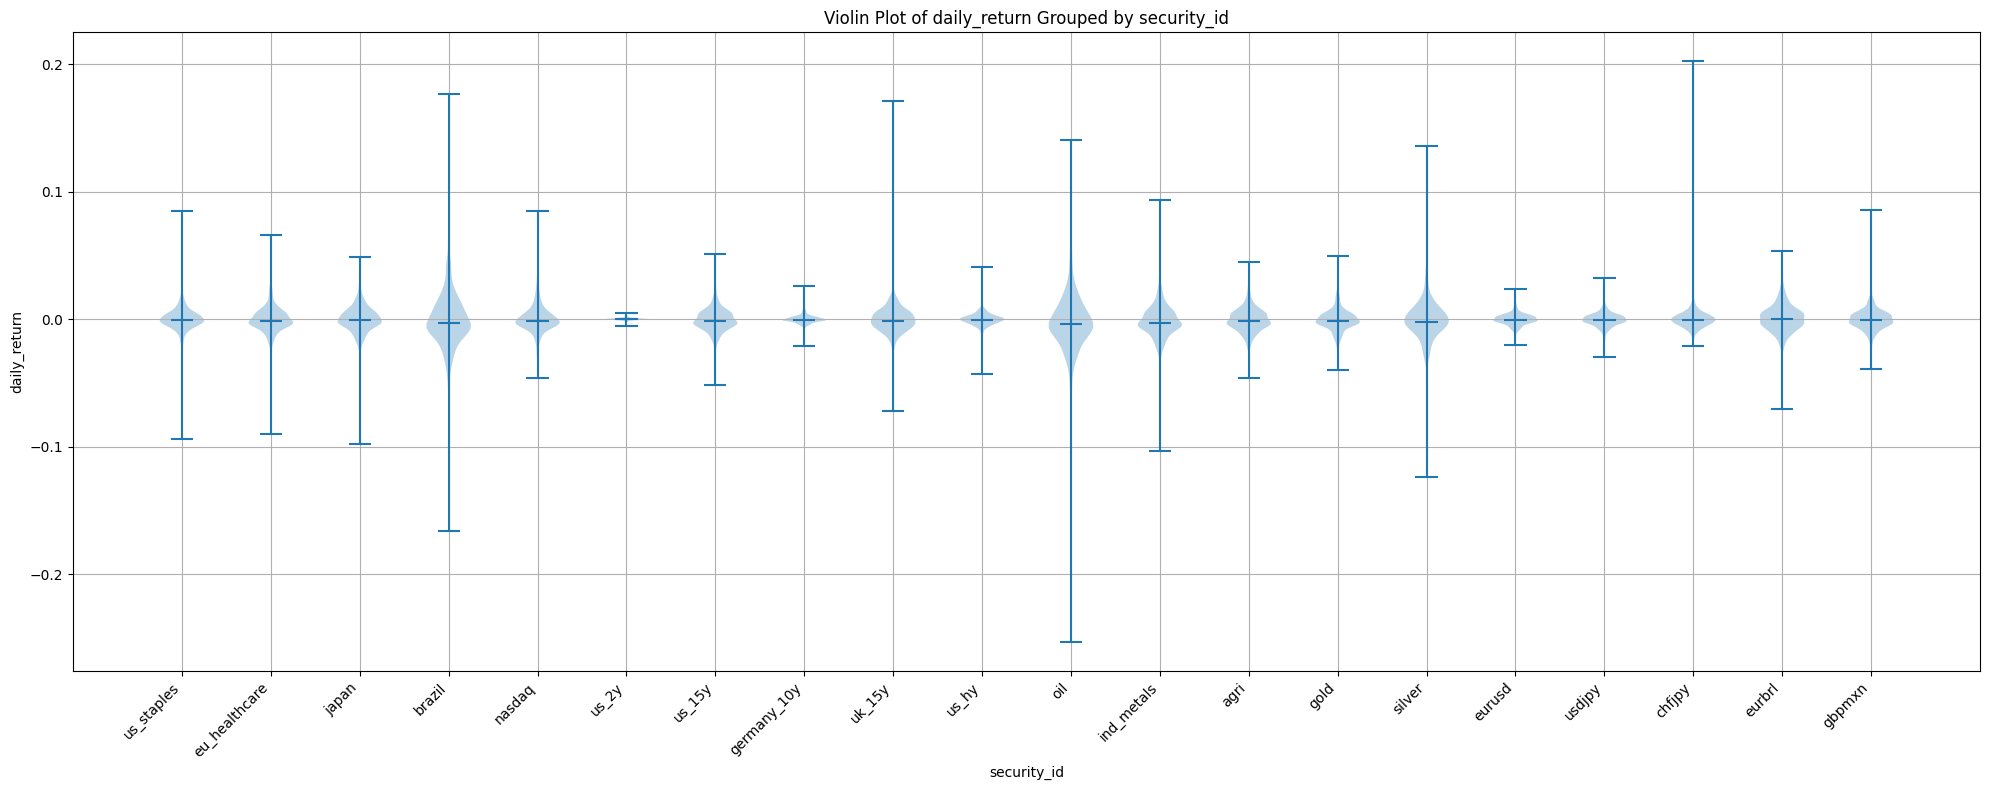

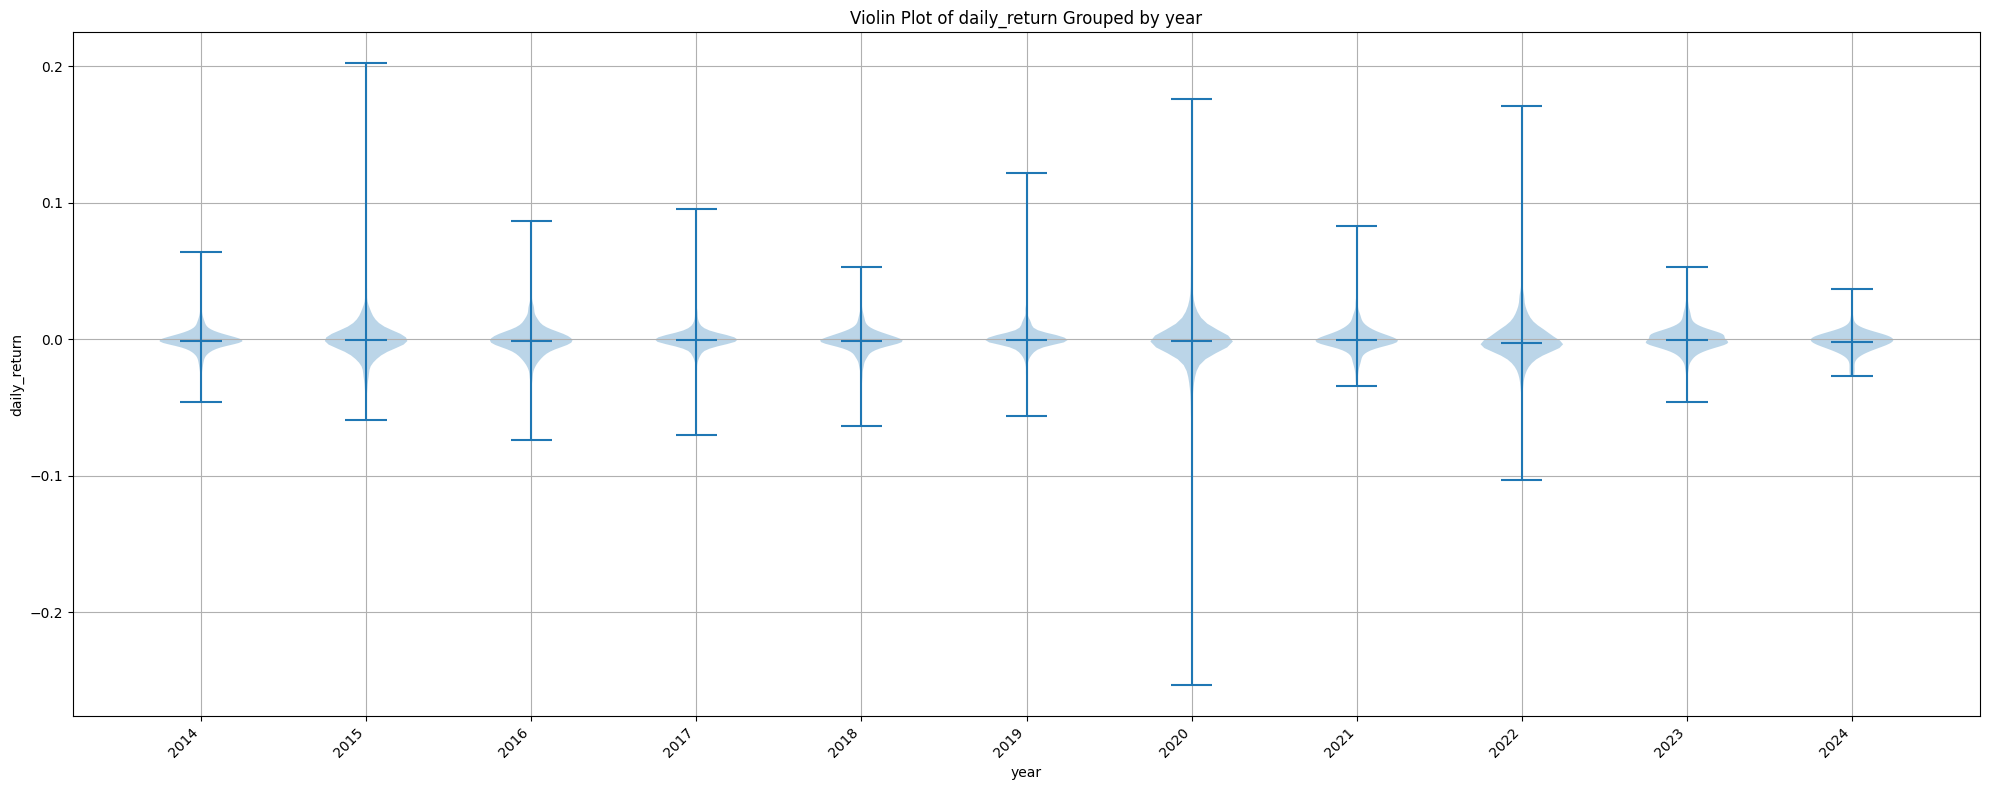

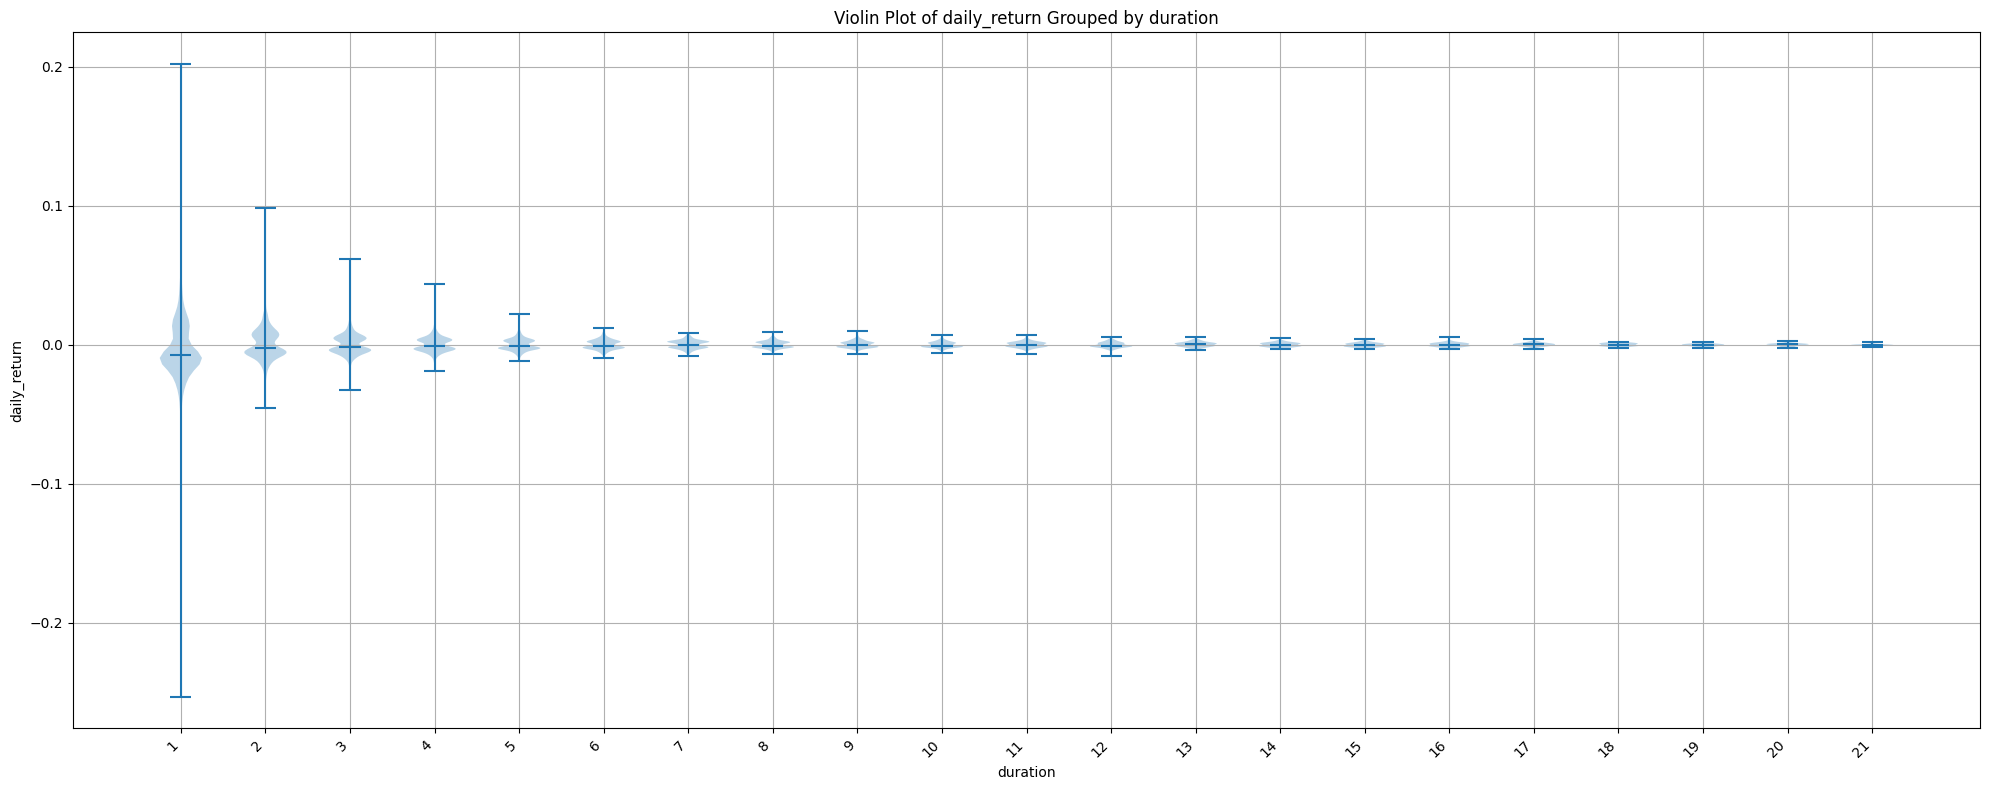

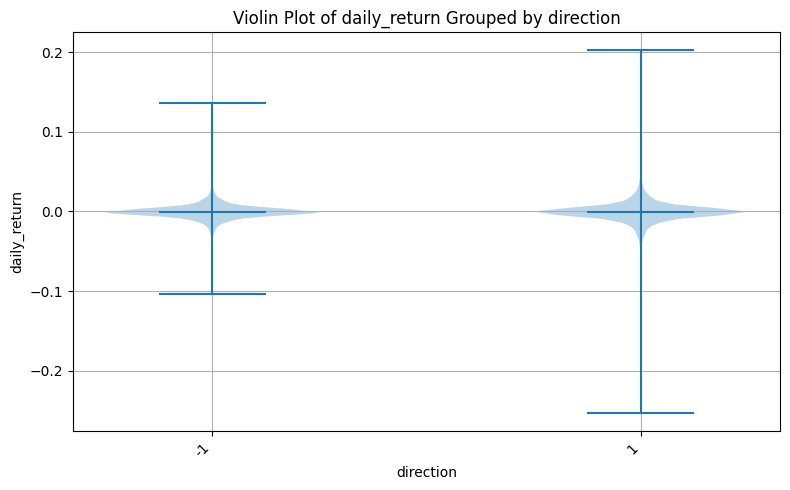

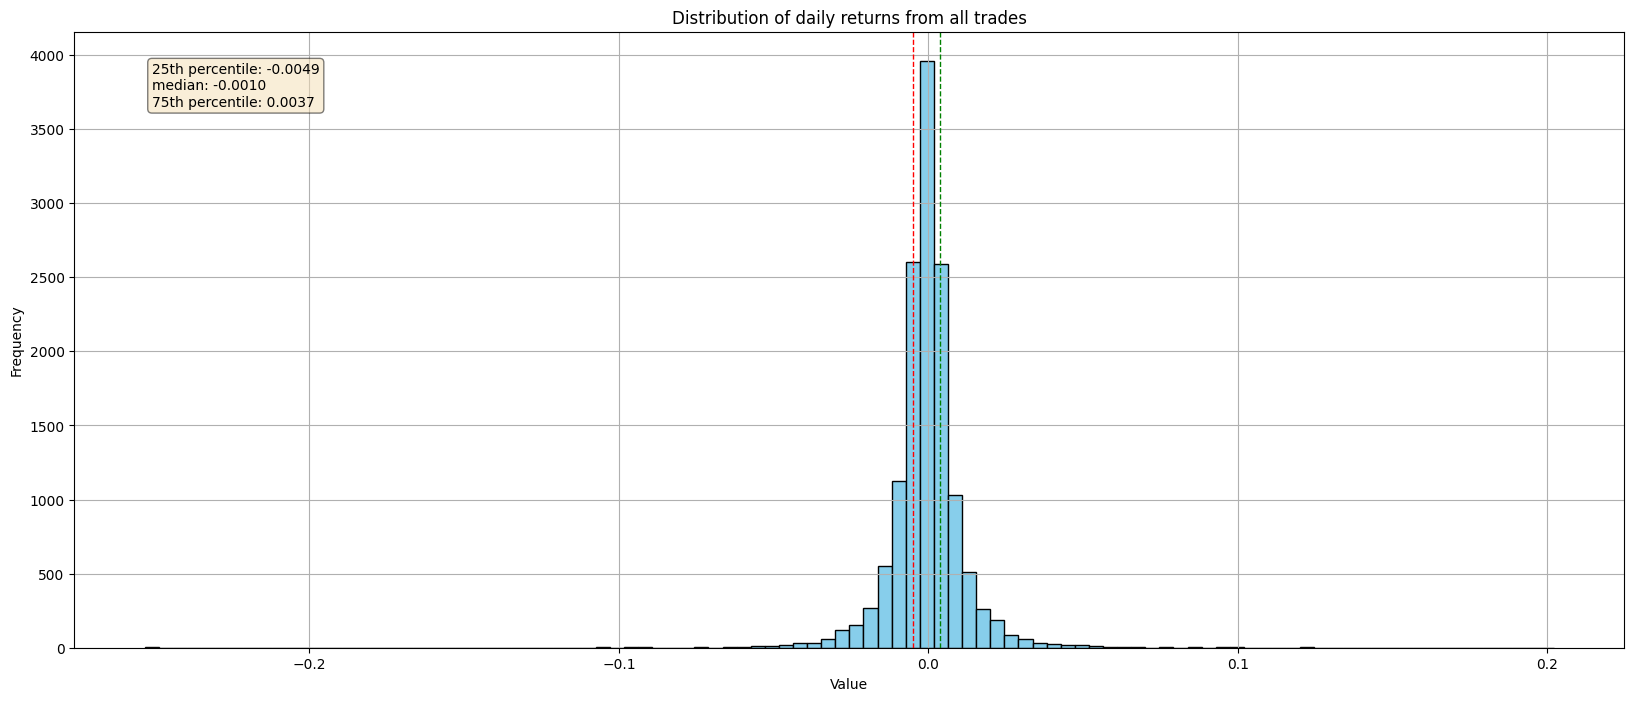

5th percentile: -0.017


In [10]:
violin_plot_grouped(trades_list, 'security_id', 'daily_return')
violin_plot_grouped(trades_list, 'year', 'daily_return')
violin_plot_grouped(trades_list.sort_values(by='duration'), 'duration', 'daily_return')
violin_plot_grouped(trades_list, 'direction', 'daily_return', figsize=(8,5))
plot_histogram(trades_list['daily_return'], 'Distribution of daily returns from all trades', figsize=(20, 8), bins=100)
trades_list.groupby('security_id')['daily_return'].describe()
print('5th percentile:', round(trades_list['daily_return'].quantile(0.05), 4))